# CIFAR-10 Images Classification using CNN

In [1]:
# Installing pytorch using pip install
!pip install torch torchvision torchaudio
!pip install torchsummary

In [2]:
# Importing necessary libraries
import os
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchsummary import summary

In [3]:
# Defining Batch Size and Transformations for Data Augmentation
batch_size = 32
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# Getting Downloads directory path
downloads_dir = os.path.join(os.path.expanduser('~'), 'Downloads')

In [5]:
# Getting Training and Testing Data
train_dataset = datasets.CIFAR10(
    root=downloads_dir,
    train=True,
    download=True,
    transform=transform,
)

test_dataset = datasets.CIFAR10(
    root=downloads_dir,
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Creating Data loaders to efficiently load and iterate over the dataset during training and testing phases
train_loader = torch.utils.data.DataLoader(
    train_dataset,          
    batch_size=batch_size,  
    shuffle=True,           
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [7]:
# CIFAR10 containning 10 kinds of labels
#   0, 1, ..., 9 correspond to the following objects 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


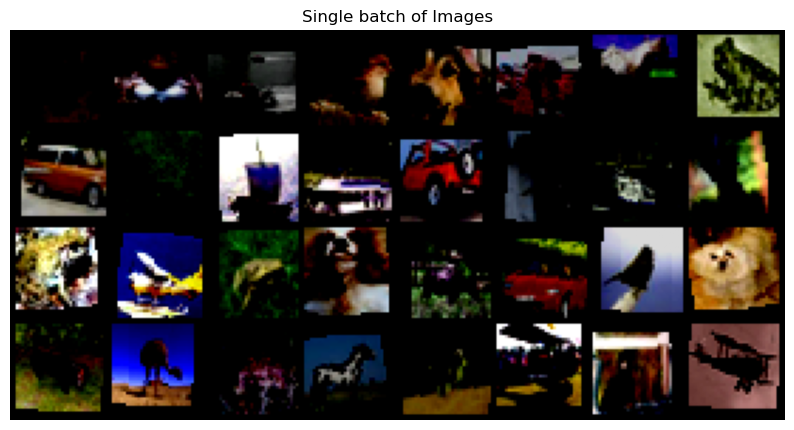

In [8]:
# Geting a single batch from the data loader
images, labels = next(iter(train_loader))

# Displaying the images in a grid
def show_batch_grid(images, labels, nrow=8):
    """
    Displaying a grid of images along with their corresponding labels.

    Arguments:
    - images (Tensor): A tensor containing batch of images.
    - labels (Tensor): A tensor containing corresponding labels for the images.
    - nrow (int): Number of images per row in the grid. Default is 8.
    """
    grid_img = make_grid(images, nrow=nrow)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title('Single batch of Images')
    plt.axis('off')
    plt.show()

show_batch_grid(images, labels)

In [9]:
# Building a simple CNN architecture model
class CNN(nn.Module):
    """
    CNN (Convolutional Neural Network) model architecture.

    This model consists of three convolutional layers followed by max pooling, and fully connected layers.

    Attributes:
    - conv1: First convolutional layer with 3 input channels, 32 output channels, 
             and a kernel size of 3x3.
    - conv2: Second convolutional layer with 32 input channels (output from conv1), 
             64 output channels, and a kernel size of 3x3.
    - conv3: Third convolutional layer with 64 input channels (output from conv2), 
             128 output channels, and a kernel size of 3x3.
    - pool: Max pooling layer with a kernel size of 2x2 and a stride of 2.
    - fc1: Fully connected layer with 128 * 4 * 4 input features (output from conv3 after pooling),
           512 output features.
    - fc2: Output layer with 512 input features (output from fc1), and 10 output classes.

    Methods:
    - forward(x): Forward pass through the CNN model.

        Arguments:
        - x: Input tensor with shape (batch_size, 3, 32, 32).

        Returns:
        - Output tensor with shape (batch_size, 10).
    """
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)  

    def forward(self, x):
        """
        Forward pass through the CNN model.

        Arguments:
        - x: Input tensor with shape (batch_size, 3, 32, 32).

        Returns:
        - Output tensor with shape (batch_size, 10).
        """
        # Forward pass through the network
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        # Flattening the feature maps
        x = x.view(-1, 128 * 4 * 4)
        # Fully connected layers
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Creating an instance of the SimpleCNN model
model = CNN()
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
         MaxPool2d-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 512]       1,049,088
            Linear-8                   [-1, 10]           5,130
Total params: 1,147,466
Trainable params: 1,147,466
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 4.38
Estimated Total Size (MB): 4.94
----------------------------------------------------------------


In [10]:
# Creating empty lists to store training and validation metrics
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

# Training the CNN model
# Defining the loss function, optimizer and weight decay factor to avoid overfitting
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001, weight_decay=1e-4)

# Defining learning rate scheduler for updation
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Defining the number of epochs
num_epochs = 15
# num_epochs = 20

# Checking if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Additional checking, trying with early stopping parameter 
# Early stopping parameter
# Initilaizing the number of epochs to wait for improvement before stopping, 
# (If the validation loss does not improve for 3 consecutive epochs, the training will be stopped to prevent overfitting and unnecessary computation).
#early_stopping_patience = 3  
# Initializing the best validation loss as infinity
#best_val_loss = float('inf')  
# Counter for epochs since last improvement
#epochs_without_improvement = 0  

# Training loop
for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        # Moving images and labels to the device 
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        
        # Computing loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Updating the running loss
        running_loss += loss.item()
        
        # Computing accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculating the training accuracy and loss
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

# Evaluating the CNN model
    # Evaluation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # There is no need to compute gradients during validation
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Accumulating loss
            val_loss += loss.item()
            
            # Computing accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculating validation loss and accuracy
    val_loss = val_loss / len(test_loader)
    val_accuracy = val_correct / val_total
    
    # Updating the learning rate
    scheduler.step()

    # Printing the epoch loss and accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Printing the validation loss and accuracy
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Storing metrics for plotting
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    # Checking if validation loss has improved
    #if val_loss < best_val_loss:
     #   best_val_loss = val_loss
      #  epochs_without_improvement = 0
    #else:
     #   epochs_without_improvement += 1

    # Early stopping checking method
    #if epochs_without_improvement >= early_stopping_patience:
     #   print("Early stopping triggered")
      #  break


Epoch [1/15], Training Loss: 1.5854, Training Accuracy: 0.4167
Validation Loss: 1.2757, Validation Accuracy: 0.5449
Epoch [2/15], Training Loss: 1.2224, Training Accuracy: 0.5633
Validation Loss: 0.9772, Validation Accuracy: 0.6549
Epoch [3/15], Training Loss: 1.0629, Training Accuracy: 0.6231
Validation Loss: 0.9597, Validation Accuracy: 0.6664
Epoch [4/15], Training Loss: 0.9716, Training Accuracy: 0.6600
Validation Loss: 0.8135, Validation Accuracy: 0.7162
Epoch [5/15], Training Loss: 0.9096, Training Accuracy: 0.6815
Validation Loss: 0.7389, Validation Accuracy: 0.7448
Epoch [6/15], Training Loss: 0.7839, Training Accuracy: 0.7247
Validation Loss: 0.6875, Validation Accuracy: 0.7614
Epoch [7/15], Training Loss: 0.7562, Training Accuracy: 0.7350
Validation Loss: 0.6791, Validation Accuracy: 0.7648
Epoch [8/15], Training Loss: 0.7438, Training Accuracy: 0.7408
Validation Loss: 0.6703, Validation Accuracy: 0.7669
Epoch [9/15], Training Loss: 0.7270, Training Accuracy: 0.7449
Validatio

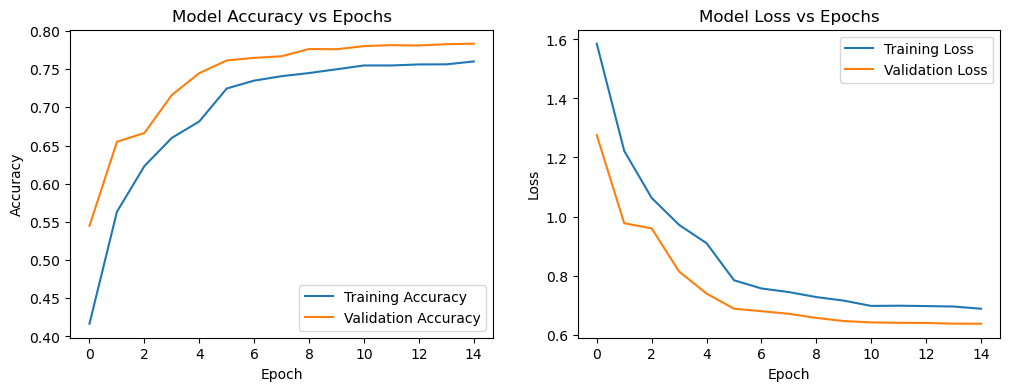

In [11]:
# Plotting the model accuracy and model loss vs epochs
plt.figure(figsize=(12, 4))

# Plotting Model Loss vs Epochs
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss vs Epochs')
plt.legend()

# Plotting Model Accuracy vs Epochs
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Epochs')
plt.legend()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


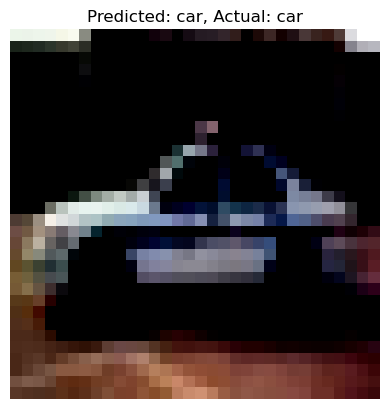

In [12]:
# CNN model for Images predictions
def check_predictions(model, test_dataset):
    """
    Function to check predictions of the CNN model on a single image from the test dataset.

    Args:
    - model (torch.nn.Module): The trained CNN model.
    - test_dataset (torch.utils.data.Dataset): The test dataset.

    Returns:
    None: Displays the image along with its predicted and actual labels.
    """
    # Switching to evaluation mode
    model.eval()

    # Getting a single test image and its label
    index = np.random.randint(len(test_dataset))
    image, label = test_dataset[index]

    # Adding batch dimension and move to device
    image = image.unsqueeze(0).to(device)  

    # CNN model making prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = classes[predicted.item()]

    # Displaying the image with its predicted label
    plt.imshow(image.squeeze().cpu().permute(1, 2, 0))
    plt.title(f'Predicted: {predicted_class}, Actual: {classes[label]}')
    plt.axis('off')
    plt.show()

# Function call to check predictions
check_predictions(model, test_dataset)
